# Export Rates


 - Searches for coherent sinking events  
 - Computes sinking rate from these by fitting a linear regression
 - Fits Martins curve power law to derive particle attenuation rates
 - Computes the Aggregate POC flux based on a bulk sinking rate 

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, '../src/')
import PrimaryProductionTools as ppt
from ExportTools import martins_curve_log, fit_export_events

# Load data

Data is binned to 10m in the vertical and 2 days in the horizontal.  
A 50 meter rolling mean and a 2 day rolling mean is then applied

In [2]:
ds_643 = xr.open_dataset('../data/seaglider/sg643/sg643_optics_v16042021-v2.nc')

custom_bin = np.r_[
    np.arange(0, 400, 10),
   ]
dive_time=ppt.time_average_per_dive(ds_643.dives,ds_643.time)
time643=np.unique(dive_time)
x=ds_643.dives
y=ds_643.depth
lat_grd=ppt.pandas_grid(ds_643.latitude,dive_time,ds_643.depth,bins=custom_bin)
lon_grd=ppt.pandas_grid(ds_643.longitude,dive_time,ds_643.depth,bins=custom_bin)


spike_grd=ppt.pandas_grid(ds_643.bbp700_spikes,dive_time,ds_643.depth,bins=custom_bin)
spike_resample=spike_grd.transpose().resample('2D').mean()
spike_running = spike_resample.rolling('2D').mean().transpose().rolling(5).mean()


In [3]:
ds_640 = xr.open_dataset('../data/seaglider/sg640/sg640_opticsv16042021.nc')
x=ds_640.time
y=ds_640.depth
custom_bin = np.r_[
    np.arange(0, 400, 10),
   ]
dive_time=ppt.time_average_per_dive(ds_640.dives,ds_640.time)
time640=np.unique(dive_time)

lat_grd=ppt.pandas_grid(ds_640.latitude,dive_time,ds_640.depth,bins=custom_bin)
lon_grd=ppt.pandas_grid(ds_640.longitude,dive_time,ds_640.depth,bins=custom_bin)



baseline_grd=ppt.pandas_grid(ds_640.bbp_baseline,dive_time,ds_640.depth,bins=custom_bin)
spike_grd=ppt.pandas_grid(ds_640.bbp_spikes,dive_time,ds_640.depth,bins=custom_bin)
# baseline_resample=baseline_grd.transpose().resample('2D').mean()
spike_resample=spike_grd.transpose().resample('2D').mean()
spike_running640 = spike_resample.rolling('2D').mean().transpose().rolling(5).mean()
# baseline_running640 = baseline_resample.rolling('2D').mean().transpose().rolling(2).mean()



# Fit export events

/Users/XNUNEI/Dropbox/My Mac (ml-181129-002)/Documents/science/roammiz/miz_export/notebooks/../src/ExportTools.py:153: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboax_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('export_events_{}.png'.format(glider_id),bboax_inches='tight')
/Users/XNUNEI/Dropbox/My Mac (ml-181129-002)/Documents/science/roammiz/miz_export/notebooks/../src/ExportTools.py:153: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboax_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('export_events_{}.png'.format(glider_id),bboax_inches='tight')


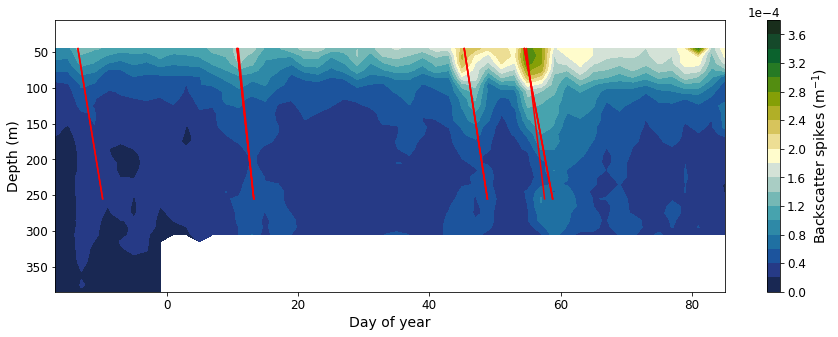

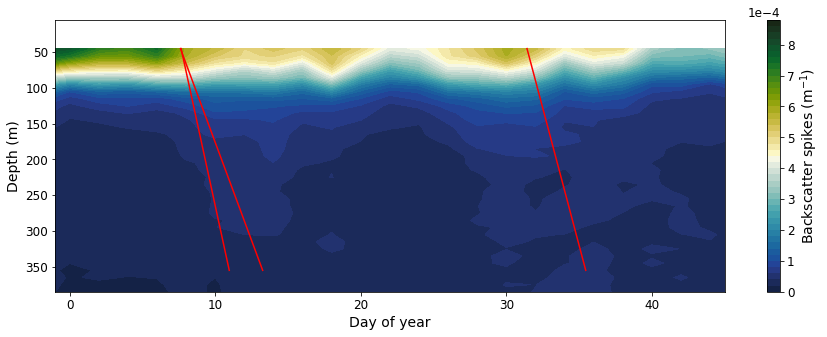

In [4]:
df643,dfR643,ax643=fit_export_events(spike_running, glider_id='SG2018',moving_window=5,
                             min_depth=50,max_depth=270,  r2_threshold=0.4,output_figure=True,levels=np.arange(0,4e-4,2e-5))
ax1=ax643.gca()
# ax1.set_title('SG2018')


df640,dfR640,ax640=fit_export_events(spike_running640, glider_id='SG2019',plot_xlim_min=-1,plot_xlim_max=45,moving_window=5,
                                   min_depth=50,max_depth=370, r2_threshold=0.4,output_figure=True,levels=np.arange(0,9e-4,2e-5))
ax=ax640.gca()
# ax.set_title('SG2019')


In [5]:
df643.sinking_rate[:].max()-df643.sinking_rate[:].min()

39.89615384615381

In [6]:
df643.sinking_rate[:].mean()

65.2414281219578

In [7]:
df640.sinking_rate[3:].mean()

65.86720321931591

In [8]:
df640.sinking_rate[:].max()-df640.sinking_rate[:].min()

54.774275895925356

# Convert backscatter to POC

In [9]:
# 643
aggPOC = np.ndarray([len(spike_running.columns),len(spike_running.index)])
for i in range(len(spike_running.index)): 
    aggPOC[:,i] = ((spike_running.iloc[i,:])
                    *35400*(spike_running.index[i]/100)**-0.28)
    
aggPOC_643=xr.DataArray(data=aggPOC.T,dims={'index','columns'},
             coords=[('index',spike_running.index.values),('columns',spike_running.columns.values)]).to_pandas()

In [10]:
# 640
aggPOC_640 = np.ndarray([len(spike_running640.columns),len(spike_running640.index)])
for i in range(len(spike_running640.index)): 
    aggPOC_640[:,i] = ((spike_running640.iloc[i,:])
                    *35400*(spike_running640.index[i]/100)**-0.28)

aggPOC_640=xr.DataArray(data=aggPOC_640.T,dims={'index','columns'},
             coords=[('index',spike_running640.index.values),('columns',spike_running640.columns.values)]).to_pandas()
    

/Users/XNUNEI/Dropbox/My Mac (ml-181129-002)/Documents/science/roammiz/miz_export/notebooks/../src/ExportTools.py:153: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboax_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('export_events_{}.png'.format(glider_id),bboax_inches='tight')


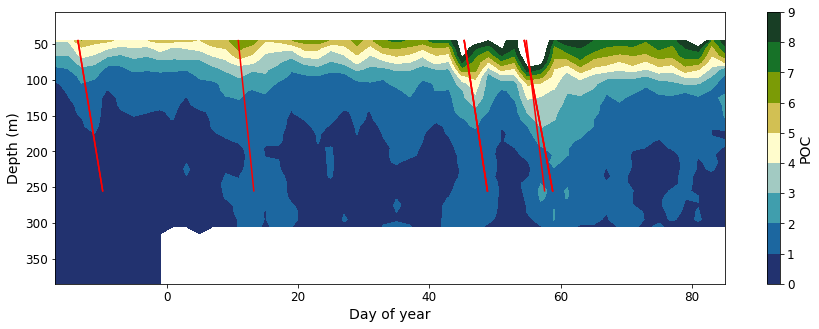

In [13]:
# Recompute flux events based on POC

df643_poc,dfR643_poc,fig=fit_export_events(aggPOC_643, glider_id='SG2018',moving_window=5,
                             min_depth=50,max_depth=270,  r2_threshold=0.5,output_figure=True,levels=np.arange(0,10,1),cbar_label='POC')

/Users/XNUNEI/Dropbox/My Mac (ml-181129-002)/Documents/science/roammiz/miz_export/notebooks/../src/ExportTools.py:153: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboax_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('export_events_{}.png'.format(glider_id),bboax_inches='tight')


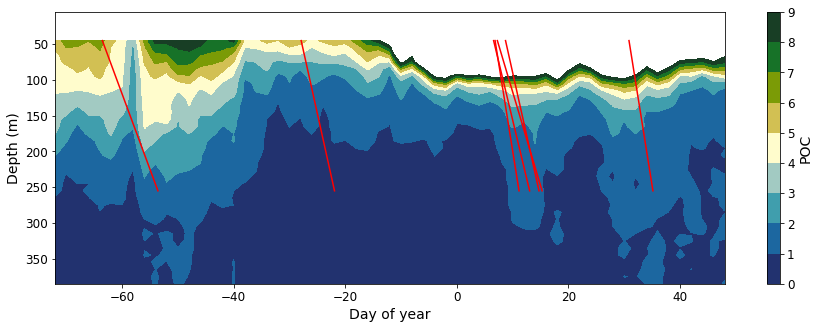

In [15]:
df640_poc,dfR640_poc,fig=fit_export_events(aggPOC_640, glider_id='SG2019', moving_window=5,
                                   min_depth=50,max_depth=270, r2_threshold=0.4,output_figure=True,levels=np.arange(0,10,1),cbar_label='POC')

# Fit Power Law
## Check this

SG643: 0.9716815019845362
SG640: 1.5919845575638152


Text(0.02, 0.93, 'b')

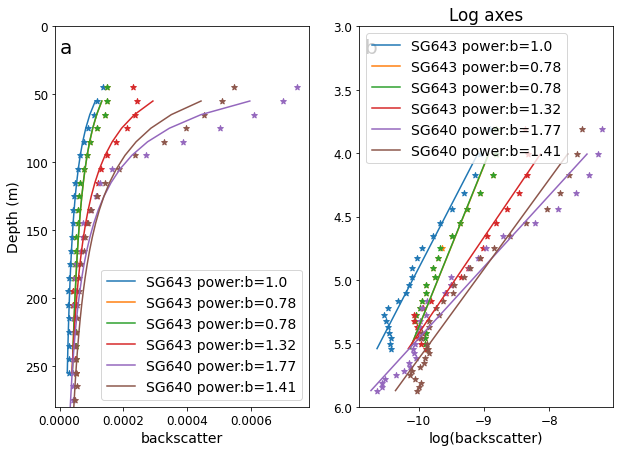

In [16]:
bpoc643=[]
bpoc640=[]

fig=plt.figure(figsize=[10,7])


ax = fig.add_subplot(121)

for i in [1,2,5,7]:
    max_spike_nomask = np.array(dfR643.iloc[i].max_spike)
    depth_nomask = np.array(dfR643.iloc[i].depth)

    max_spike = np.array(dfR643.iloc[i].max_spike)
    depth = np.array(dfR643.iloc[i].depth)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X643=max_spike[mask]
    Y=depth[mask]

    plt.scatter((max_spike_nomask),(depth_nomask),marker='*')

    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X643)
    bpoc643.append(popt_log[1])
    plt.plot((ydatafit_log),(Y),label='SG643 power:b={}'.format(popt_log[1].round(2)))

    plt.legend(loc='lower left')

    
for i in [2,4]:
    max_spike_nomask = np.array(dfR640.iloc[i].max_spike)+0
    depth_nomask = np.array(dfR640.iloc[i].depth)

    max_spike = np.array(dfR640.iloc[i].max_spike)+0
    depth = np.array(dfR640.iloc[i].depth)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X640=max_spike[mask]
    Y=depth[mask]

    plt.scatter((max_spike_nomask),(depth_nomask),marker='*')

    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X640)
    bpoc640.append(popt_log[1])
    plt.plot((ydatafit_log),(Y),label='SG640 power:b={}'.format(popt_log[1].round(2)))

    plt.legend()
    plt.ylim(280,0)

    
plt.ylabel('Depth (m)')

bpoc643=np.array(bpoc643)
bpoc640=np.array(bpoc640)

print('SG643:',np.nanmean(bpoc643))
print('SG640:',np.nanmean(bpoc640))
plt.xlabel('backscatter')


ax2 = fig.add_subplot(122)

for i in [1,2,5,7]:
    max_spike_nomask = np.array(dfR643.iloc[i].max_spike)
    depth_nomask = np.array(dfR643.iloc[i].depth)

    max_spike = np.array(dfR643.iloc[i].max_spike)
    depth = np.array(dfR643.iloc[i].depth)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X643=max_spike[mask]
    Y=depth[mask]

    plt.scatter(np.log(max_spike_nomask),np.log(depth_nomask),marker='*')

    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X643)
    plt.plot(np.log(ydatafit_log),np.log(Y),label='SG643 power:b={}'.format(popt_log[1].round(2)))

    plt.legend(loc='lower left')

    
for i in [2,4]:
    max_spike_nomask = np.array(dfR640.iloc[i].max_spike)+0
    depth_nomask = np.array(dfR640.iloc[i].depth)

    max_spike = np.array(dfR640.iloc[i].max_spike)+0
    depth = np.array(dfR640.iloc[i].depth)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X640=max_spike[mask]
    Y=depth[mask]


    plt.scatter(np.log(max_spike_nomask),np.log(depth_nomask),marker='*')
    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X640)
    plt.plot(np.log(ydatafit_log),np.log(Y),label='SG640 power:b={}'.format(popt_log[1].round(2)))

    plt.legend()
#     # 
    plt.ylim(6,3)

    
# plt.ylabel('Depth (m)')

ax2.set_xlabel('log(backscatter)')
ax2.set_title('Log axes')

ax.text(0.02,0.93,'a',transform=ax.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax2.text(0.02,0.93,'b',transform=ax2.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))

# plt.savefig('../results/figures/supp_martins_curves.png',dpi=150,bbox_inches='tight')

SG643: 0.19079821369882394
SG640: 0.1051732247699293


Text(0.02, 0.94, 'g')

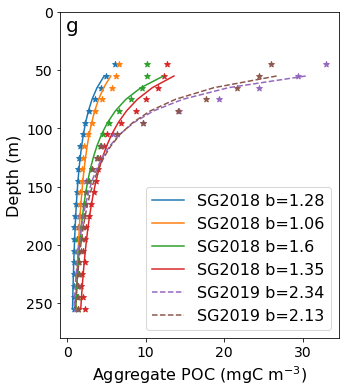

In [17]:

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'font.size': 16})

bpoc643=[]
bpoc640=[]

fig,ax=plt.subplots(1,1,figsize=[5,6])


for i in [1,2,5,7]:
    max_spike_nomask = np.array(dfR643_poc.iloc[i].max_spike)
    depth_nomask = np.array(dfR643_poc.iloc[i].depth)

    max_spike = np.array(dfR643_poc.iloc[i].max_spike)
    depth = np.array(dfR643_poc.iloc[i].depth)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X643=max_spike[mask]
    Y=depth[mask]

    ax.scatter((max_spike_nomask),(depth_nomask),marker='*')

    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X643,)
    bpoc643.append(popt_log[1])
    ax.plot((ydatafit_log),Y,label='SG2018 b={}'.format(popt_log[1].round(2)))

    plt.legend(loc='lower left')

    
for i in [2,5]:
    max_spike_nomask = np.array(dfR640_poc.iloc[i].max_spike)+0
    depth_nomask = np.array(dfR640_poc.iloc[i].depth)

    max_spike = np.array(dfR640_poc.iloc[i].max_spike)+0
    depth = np.array(dfR640_poc.iloc[i].depth)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X640=max_spike[mask]
    Y=depth[mask]

    ax.scatter((max_spike_nomask),(depth_nomask),marker='*')

    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X640,)
    bpoc640.append(popt_log[1])
    ax.plot((ydatafit_log),Y,linestyle='--',label='SG2019 b={}'.format(popt_log[1].round(2)))

    plt.legend()
    ax.set_ylim(280,0)

    
ax.set_ylabel('Depth (m)')

bpoc643=np.array(bpoc643)
bpoc640=np.array(bpoc640)

print('SG643:',np.nanstd(bpoc643))
print('SG640:',np.nanstd(bpoc640))
ax.set_xlabel('Aggregate POC (mgC m$^{-3}$)')

plt.text(0.02,0.94,'g',transform=ax.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))

# plt.savefig('../results/figures/fig3_martins_curves.png',dpi=150,bbox_inches='tight',transparency=True)

SG643: 0.19079821369882394
SG640: 0.06522443530375788


Text(0.02, 0.93, 'b')

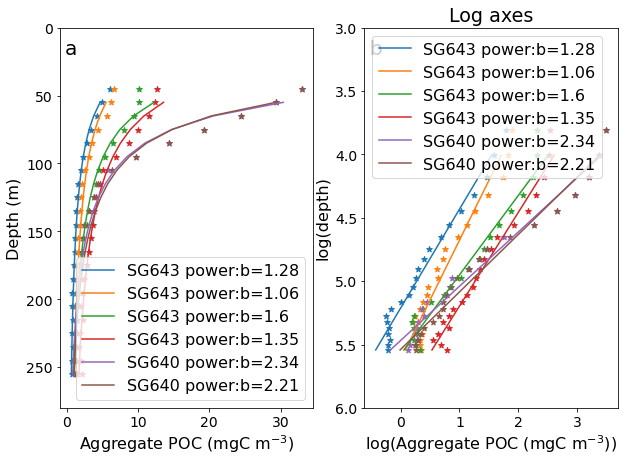

In [18]:
bpoc643=[]
bpoc640=[]

fig=plt.figure(figsize=[10,7])


ax = fig.add_subplot(121)

for i in [1,2,5,7]:
    max_spike_nomask = np.array(dfR643_poc.iloc[i].max_spike)
    depth_nomask = np.array(dfR643_poc.iloc[i].depth)

    max_spike = np.array(dfR643_poc.iloc[i].max_spike)
    depth = np.array(dfR643_poc.iloc[i].depth)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X643=max_spike[mask]
    Y=depth[mask]

    plt.scatter((max_spike_nomask),(depth_nomask),marker='*')

    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X643,)
    bpoc643.append(popt_log[1])
    plt.plot((ydatafit_log),Y,label='SG643 power:b={}'.format(popt_log[1].round(2)))

    plt.legend(loc='lower left')

    
for i in [2,4]:
    max_spike_nomask = np.array(dfR640_poc.iloc[i].max_spike)+0
    depth_nomask = np.array(dfR640_poc.iloc[i].depth)

    max_spike = np.array(dfR640_poc.iloc[i].max_spike)+0
    depth = np.array(dfR640_poc.iloc[i].depth)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X640=max_spike[mask]
    Y=depth[mask]

    plt.scatter((max_spike_nomask),(depth_nomask),marker='*')

    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X640,)
    bpoc640.append(popt_log[1])
    plt.plot((ydatafit_log),Y,label='SG640 power:b={}'.format(popt_log[1].round(2)))

    plt.legend()
    plt.ylim(280,0)

    
plt.ylabel('Depth (m)')

bpoc643=np.array(bpoc643)
bpoc640=np.array(bpoc640)

print('SG643:',np.nanstd(bpoc643))
print('SG640:',np.nanstd(bpoc640))
plt.xlabel('Aggregate POC (mgC m$^{-3}$)')


ax2 = fig.add_subplot(122)

for i in [1,2,5,7]:
    max_spike_nomask = np.array(dfR643_poc.iloc[i].max_spike)
    depth_nomask = np.array(dfR643_poc.iloc[i].depth)

    max_spike = np.array(dfR643_poc.iloc[i].max_spike)
    depth = np.array(dfR643_poc.iloc[i].depth)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X643=max_spike[mask]
    Y=depth[mask]

    plt.scatter(np.log(max_spike_nomask),np.log(depth_nomask),marker='*')

    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X643)
    plt.plot(np.log(ydatafit_log),np.log(Y),label='SG643 power:b={}'.format(popt_log[1].round(2)))

    plt.legend(loc='lower left')

    
for i in [2,4]:
    max_spike_nomask = np.array(dfR640_poc.iloc[i].max_spike)+0
    depth_nomask = np.array(dfR640_poc.iloc[i].depth)

    max_spike = np.array(dfR640_poc.iloc[i].max_spike)+0
    depth = np.array(dfR640_poc.iloc[i].depth)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X640=max_spike[mask]
    Y=depth[mask]


    plt.scatter(np.log(max_spike_nomask),np.log(depth_nomask),marker='*')
    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X640)
    plt.plot(np.log(ydatafit_log),np.log(Y),label='SG640 power:b={}'.format(popt_log[1].round(2)))

    plt.legend()
#     # 
    plt.ylim(6,3)

    
# plt.ylabel('Depth (m)')

ax2.set_xlabel('log(Aggregate POC (mgC m$^{-3}$))')
ax2.set_ylabel('log(depth)')
ax2.set_title('Log axes')

ax.text(0.02,0.93,'a',transform=ax.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax2.text(0.02,0.93,'b',transform=ax2.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))

# plt.savefig('../results/figures/supp_martins_curves.png',dpi=150,bbox_inches='tight')

## Fit curve to profiles (not extracted regression points)

The result is essentially the same as with the regressions line data

SG643: 1.1972156805170375
SG640: 2.0904452498123725


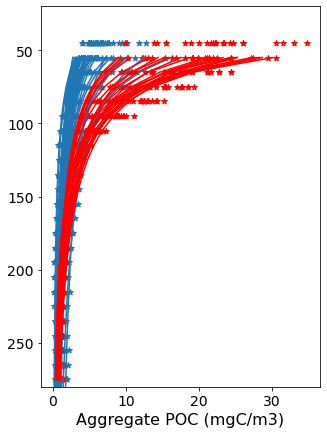

In [19]:

# all profiles
bpoc643=[]
bpoc640=[]
from scipy.optimize import curve_fit

plt.figure(figsize=[5,7])

for i in range(len(aggPOC_643)):
    max_spike_nomask = np.array(aggPOC_643.iloc[:,i])
    depth_nomask = np.array(aggPOC_643.index)

    max_spike = np.array(aggPOC_643.iloc[:,i])
    depth = np.array(aggPOC_643.index)
    max_spike[(depth<50.)]=np.nan
#     max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X643=max_spike[mask]
    Y=depth[mask]

    plt.scatter(max_spike_nomask,depth_nomask,marker='*',c='tab:blue')
    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X643)
    bpoc643.append(popt_log[1])

    plt.plot(ydatafit_log,Y,label='power:b={}'.format(popt_log[1].round(2)),c='tab:blue')


    plt.ylim(250,20)
    
for i in np.arange(36,61,1):
    max_spike_nomask = np.array(aggPOC_640.iloc[:,i])
    depth_nomask = np.array(aggPOC_640.index)

    max_spike = np.array(aggPOC_640.iloc[:,i])
    depth = np.array(aggPOC_640.index)
    max_spike[(depth<50.)]=np.nan
    max_spike[(depth>=280.)]=np.nan

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X640=max_spike[mask]
    Y=depth[mask]
    plt.scatter(max_spike_nomask,depth_nomask,marker='*',c='red')
    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X640)
    bpoc640.append(popt_log[1])
    plt.plot(ydatafit_log,Y,label='power:b={}'.format(popt_log[1].round(2)),c='red')    # 
    plt.ylim(280,20)

bpoc643=np.array(bpoc643)
bpoc640=np.array(bpoc640)
plt.xlabel('Aggregate POC (mgC/m3)')

print('SG643:',np.nanmean(bpoc643))
print('SG640:',np.nanmean(bpoc640))



# Compute Aggregate POC Flux
Using a mean sinking rate of 65 m

In [20]:
# Aggregate POC flux

sinking_rate = 65
aggPOC_flux = np.ndarray([len(spike_running.columns),len(spike_running.index)])
for i in range(len(spike_running.index)): 
    aggPOC_flux[:,i] = ((spike_running.iloc[i,:])
                    *35400*sinking_rate*(spike_running.index[i]/100)**-0.28)
#                     *35400*df.sinking_rate.mean()*(spike_running.index[i]/100)**-0.28)

In [21]:
aggPOC_flux643=xr.DataArray(data=aggPOC_flux.T,dims={'index','columns'},
             coords=[('index',spike_running.index.values),('columns',spike_running.columns.values)],name='large_particle_flux')#.to_pandas()

In [22]:
# aggPOC_flux643.to_netcdf('../results/data/export643.nc')

In [23]:
aggPOC_flux640bbp = np.ndarray([len(spike_running640.columns),len(spike_running640.index)])
for i in range(len(spike_running640.index)): 
    aggPOC_flux640bbp[:,i] = ((spike_running640.iloc[i,:])
                    *35400*sinking_rate*(spike_running640.index[i]/100)**-0.28)  # select only events that occur during at 60S
#                     *35400*df640.sinking_rate[2:].mean()*(spike_running640.index[i]/100)**-0.28)  # select only events that occur during at 60S

In [24]:
aggPOC_flux640=xr.DataArray(data=aggPOC_flux640bbp.T,dims={'index','columns'},
             coords=[('index',spike_running640.index.values),('columns',spike_running640.columns.values)],name='large_particle_flux')#.to_pandas()

In [ ]:
# aggPOC_flux640.to_netcdf('../results/data/export640.nc')